In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [3]:
disease_types = ['Chili_Healthy','Chili_Leaf_Curl','Chili_Leaf_Spot','Chili_Whitefly','Chili_Yellowish','Paddy_Brown_Spot','Paddy_Healthy','Paddy_Hispa','Paddy_Leaf_Blast']
data_dir = './PlantDataSet/'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
715,Paddy_Leaf_Blast/IMG_5504.jpg,8,Paddy_Leaf_Blast
716,Paddy_Leaf_Blast/IMG_5505.jpg,8,Paddy_Leaf_Blast
717,Paddy_Leaf_Blast/IMG_5507.jpg,8,Paddy_Leaf_Blast
718,Paddy_Leaf_Blast/IMG_5508.jpg,8,Paddy_Leaf_Blast
719,Paddy_Leaf_Blast/IMG_5516.jpg,8,Paddy_Leaf_Blast


In [5]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Chili_Yellowish/Cabai virus kuning34.jpg,4,Chili_Yellowish
1,Chili_Whitefly/images - 2021-05-19T012613.186.jpg,3,Chili_Whitefly
2,Chili_Healthy/Cabai sehat079.jpg,0,Chili_Healthy
3,Chili_Leaf_Spot/leaf spot38.jpg,2,Chili_Leaf_Spot
4,Paddy_Brown_Spot/IMG_3165.jpg,5,Paddy_Brown_Spot


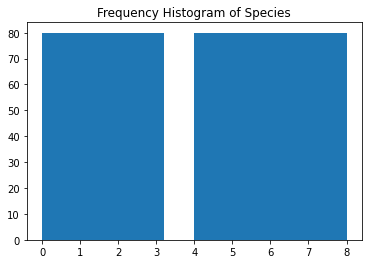

<Figure size 864x864 with 0 Axes>

In [6]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

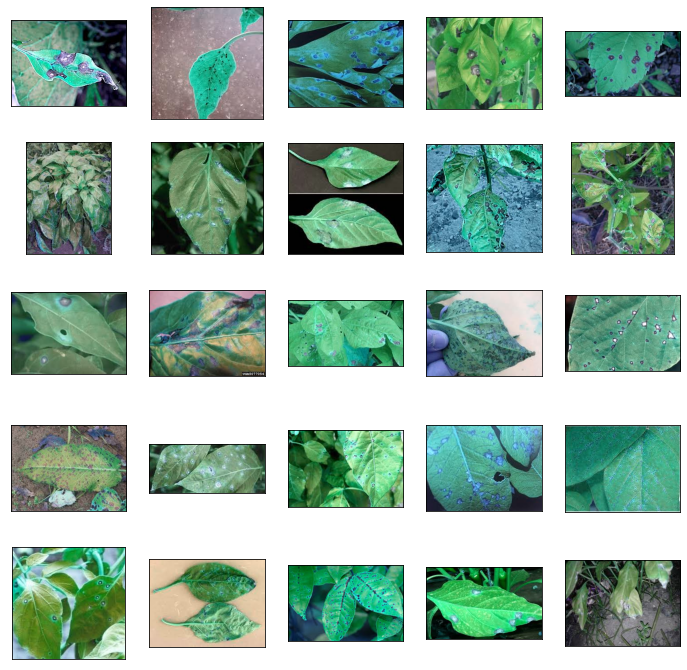

In [7]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Chili_Leaf_Spot', 5, 5)

In [8]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

720it [00:27, 26.21it/s]

Train Shape: (720, 64, 64, 3)


In [10]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [11]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

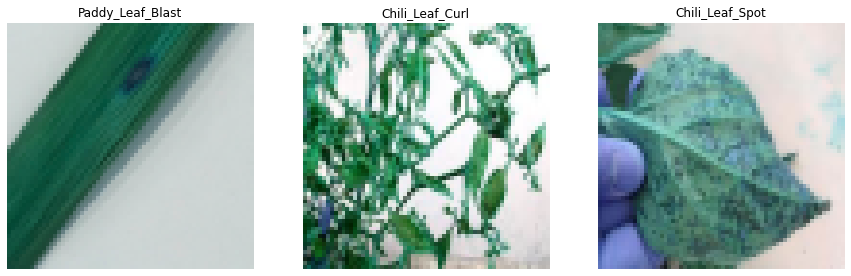

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [13]:
EPOCHS = 500
SIZE=64
N_ch=3

In [14]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [15]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('PlantDiseaseModel.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)              

Epoch 40/500

Epoch 00040: val_loss did not improve from 1.65303
9/9 - 14s - loss: 1.2225 - accuracy: 0.5486 - val_loss: 1.6925 - val_accuracy: 0.5069
Epoch 41/500

Epoch 00041: val_loss did not improve from 1.65303
9/9 - 15s - loss: 1.1766 - accuracy: 0.5660 - val_loss: 1.7741 - val_accuracy: 0.5417
Epoch 42/500

Epoch 00042: val_loss did not improve from 1.65303
9/9 - 14s - loss: 1.1025 - accuracy: 0.5694 - val_loss: 1.7391 - val_accuracy: 0.4931
Epoch 43/500

Epoch 00043: val_loss improved from 1.65303 to 1.54130, saving model to PlantDiseaseModel.h5
9/9 - 15s - loss: 1.1959 - accuracy: 0.5677 - val_loss: 1.5413 - val_accuracy: 0.5139
Epoch 44/500

Epoch 00044: val_loss improved from 1.54130 to 1.44946, saving model to PlantDiseaseModel.h5
9/9 - 15s - loss: 1.0900 - accuracy: 0.5903 - val_loss: 1.4495 - val_accuracy: 0.5278
Epoch 45/500

Epoch 00045: val_loss did not improve from 1.44946
9/9 - 15s - loss: 1.0726 - accuracy: 0.6042 - val_loss: 1.5415 - val_accuracy: 0.5278
Epoch 46/5


Epoch 00089: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.7941 - accuracy: 0.6823 - val_loss: 1.2164 - val_accuracy: 0.6111
Epoch 90/500

Epoch 00090: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.7672 - accuracy: 0.6858 - val_loss: 1.2676 - val_accuracy: 0.5833
Epoch 91/500

Epoch 00091: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.7751 - accuracy: 0.6840 - val_loss: 1.2784 - val_accuracy: 0.5625
Epoch 92/500

Epoch 00092: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.7419 - accuracy: 0.6823 - val_loss: 1.1985 - val_accuracy: 0.5903
Epoch 93/500

Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00093: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.7474 - accuracy: 0.6979 - val_loss: 1.1337 - val_accuracy: 0.5903
Epoch 94/500

Epoch 00094: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.7352 - accuracy: 0.6962 - val_loss: 1.1625 - val_accuracy: 0.5833
Epoch 95/500

Epoch 00095: val_loss did no

Epoch 139/500

Epoch 00139: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.5863 - accuracy: 0.7465 - val_loss: 1.5368 - val_accuracy: 0.5417
Epoch 140/500

Epoch 00140: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.5941 - accuracy: 0.7465 - val_loss: 1.4953 - val_accuracy: 0.5417
Epoch 141/500

Epoch 00141: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.6183 - accuracy: 0.7274 - val_loss: 1.5211 - val_accuracy: 0.5486
Epoch 142/500

Epoch 00142: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.5991 - accuracy: 0.7378 - val_loss: 1.5927 - val_accuracy: 0.5417
Epoch 143/500

Epoch 00143: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00143: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.5659 - accuracy: 0.7517 - val_loss: 1.5792 - val_accuracy: 0.5347
Epoch 144/500

Epoch 00144: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.6060 - accuracy: 0.7240 - val_loss: 1.5929 - val_accuracy: 0.5347
Epoch 145/500

Epoch 00


Epoch 00189: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.4737 - accuracy: 0.7899 - val_loss: 1.5929 - val_accuracy: 0.5764
Epoch 190/500

Epoch 00190: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.4450 - accuracy: 0.7986 - val_loss: 1.5983 - val_accuracy: 0.5625
Epoch 191/500

Epoch 00191: val_loss did not improve from 0.95855
9/9 - 16s - loss: 0.4907 - accuracy: 0.7830 - val_loss: 1.5654 - val_accuracy: 0.5486
Epoch 192/500

Epoch 00192: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.5024 - accuracy: 0.7760 - val_loss: 1.5185 - val_accuracy: 0.5694
Epoch 193/500

Epoch 00193: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00193: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.4959 - accuracy: 0.8021 - val_loss: 1.4861 - val_accuracy: 0.5972
Epoch 194/500

Epoch 00194: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.4975 - accuracy: 0.7760 - val_loss: 1.5546 - val_accuracy: 0.5694
Epoch 195/500

Epoch 00195: val_loss 

Epoch 240/500

Epoch 00240: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00240: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3833 - accuracy: 0.8455 - val_loss: 1.5034 - val_accuracy: 0.6042
Epoch 241/500

Epoch 00241: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.4653 - accuracy: 0.7917 - val_loss: 1.4542 - val_accuracy: 0.6319
Epoch 242/500

Epoch 00242: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.4490 - accuracy: 0.8125 - val_loss: 1.5518 - val_accuracy: 0.6042
Epoch 243/500

Epoch 00243: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.4354 - accuracy: 0.8073 - val_loss: 1.5421 - val_accuracy: 0.6111
Epoch 244/500

Epoch 00244: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.4351 - accuracy: 0.8316 - val_loss: 1.4918 - val_accuracy: 0.5972
Epoch 245/500

Epoch 00245: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00245: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.4102 - accuracy: 0.8160 

Epoch 290/500

Epoch 00290: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00290: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3958 - accuracy: 0.8229 - val_loss: 1.8490 - val_accuracy: 0.5694
Epoch 291/500

Epoch 00291: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3741 - accuracy: 0.8385 - val_loss: 1.4779 - val_accuracy: 0.6042
Epoch 292/500

Epoch 00292: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3935 - accuracy: 0.8385 - val_loss: 1.4708 - val_accuracy: 0.6042
Epoch 293/500

Epoch 00293: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3898 - accuracy: 0.8403 - val_loss: 1.4832 - val_accuracy: 0.6111
Epoch 294/500

Epoch 00294: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3520 - accuracy: 0.8524 - val_loss: 1.6909 - val_accuracy: 0.5625
Epoch 295/500

Epoch 00295: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00295: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3916 - accuracy: 0.8351 


Epoch 00340: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00340: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3200 - accuracy: 0.8698 - val_loss: 1.6349 - val_accuracy: 0.5694
Epoch 341/500

Epoch 00341: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3437 - accuracy: 0.8542 - val_loss: 1.5890 - val_accuracy: 0.5903
Epoch 342/500

Epoch 00342: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3282 - accuracy: 0.8611 - val_loss: 1.4751 - val_accuracy: 0.6042
Epoch 343/500

Epoch 00343: val_loss did not improve from 0.95855
9/9 - 16s - loss: 0.3124 - accuracy: 0.8733 - val_loss: 1.6007 - val_accuracy: 0.6042
Epoch 344/500

Epoch 00344: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3105 - accuracy: 0.8785 - val_loss: 1.4519 - val_accuracy: 0.6111
Epoch 345/500

Epoch 00345: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00345: val_loss did not improve from 0.95855
9/9 - 14s - loss: 0.3158 - accuracy: 0.8681 - val_loss: 1.

Epoch 390/500

Epoch 00390: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00390: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2466 - accuracy: 0.8993 - val_loss: 1.8237 - val_accuracy: 0.5625
Epoch 391/500

Epoch 00391: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2895 - accuracy: 0.8750 - val_loss: 1.5486 - val_accuracy: 0.6042
Epoch 392/500

Epoch 00392: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2795 - accuracy: 0.8802 - val_loss: 1.4782 - val_accuracy: 0.5764
Epoch 393/500

Epoch 00393: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2640 - accuracy: 0.8976 - val_loss: 1.6488 - val_accuracy: 0.5764
Epoch 394/500

Epoch 00394: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.3281 - accuracy: 0.8681 - val_loss: 1.6529 - val_accuracy: 0.5833
Epoch 395/500

Epoch 00395: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00395: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2944 - accuracy: 0.8976 

Epoch 440/500

Epoch 00440: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00440: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2610 - accuracy: 0.9028 - val_loss: 1.5277 - val_accuracy: 0.6250
Epoch 441/500

Epoch 00441: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2546 - accuracy: 0.9010 - val_loss: 1.8239 - val_accuracy: 0.5694
Epoch 442/500

Epoch 00442: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2323 - accuracy: 0.9028 - val_loss: 1.7983 - val_accuracy: 0.5556
Epoch 443/500

Epoch 00443: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2468 - accuracy: 0.8993 - val_loss: 1.5687 - val_accuracy: 0.5972
Epoch 444/500

Epoch 00444: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2225 - accuracy: 0.9028 - val_loss: 1.4570 - val_accuracy: 0.6389
Epoch 445/500

Epoch 00445: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00445: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2005 - accuracy: 0.9271 

Epoch 490/500

Epoch 00490: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.1808 - accuracy: 0.9236 - val_loss: 1.7487 - val_accuracy: 0.6042
Epoch 491/500

Epoch 00491: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.1861 - accuracy: 0.9253 - val_loss: 1.6245 - val_accuracy: 0.6319
Epoch 492/500

Epoch 00492: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.2209 - accuracy: 0.9219 - val_loss: 1.5758 - val_accuracy: 0.6181
Epoch 493/500

Epoch 00493: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00493: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.1960 - accuracy: 0.9271 - val_loss: 1.4742 - val_accuracy: 0.6042
Epoch 494/500

Epoch 00494: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.1774 - accuracy: 0.9358 - val_loss: 1.4281 - val_accuracy: 0.6389
Epoch 495/500

Epoch 00495: val_loss did not improve from 0.95855
9/9 - 18s - loss: 0.1895 - accuracy: 0.9288 - val_loss: 1.3800 - val_accuracy: 0.6389
Epoch 496/500

Epoch 00

In [16]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

5/5 [==============================] - 1s 156ms/step - loss: 1.5008 - accuracy: 0.6042
Final Loss: 1.5007842779159546, Final Accuracy: 0.6041666865348816


Text(0.5, 144.41374999999996, 'Predicted')

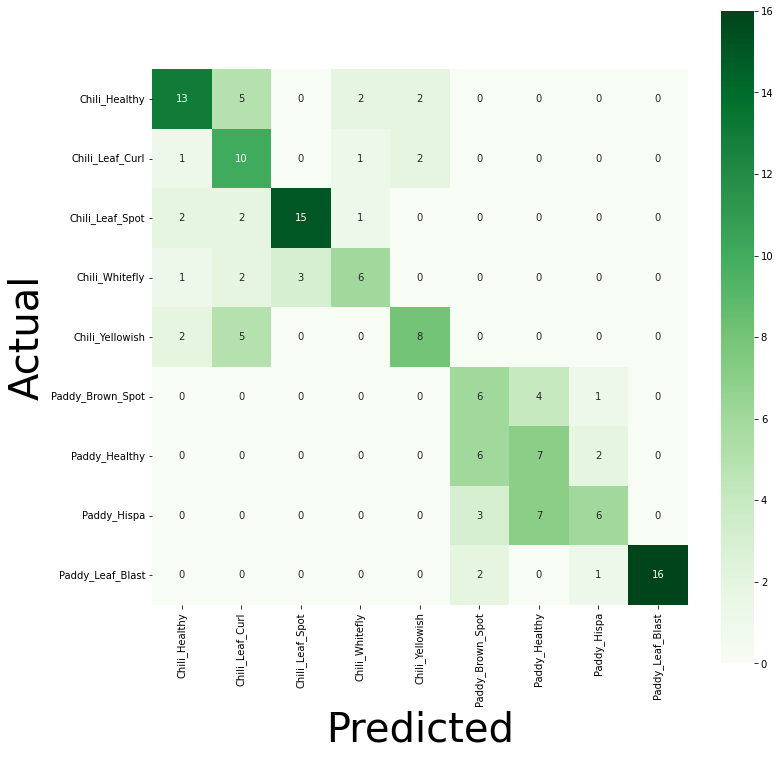

In [17]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

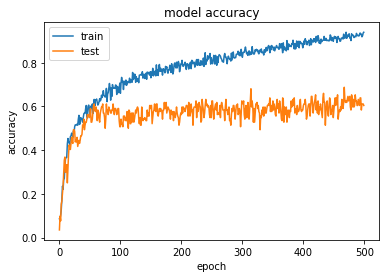

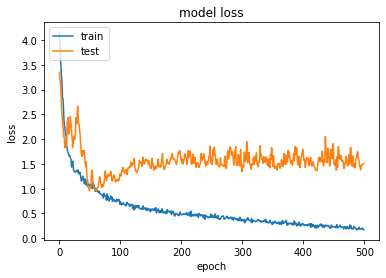

In [18]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[1.13347024e-02 1.22876856e-02 5.75593635e-02 8.97907555e-01
 2.77020945e-03 1.17130097e-04 1.22899219e-04 6.34985045e-04
 1.00962534e-04 2.72010663e-03 4.48198244e-03 3.26968916e-03
 3.77784832e-03 1.78040785e-03 1.13475614e-03]


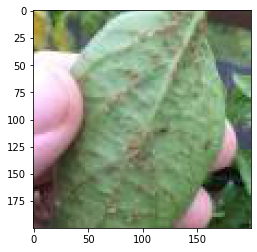

Prediction: Chili_Whitefly


In [38]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('../Chili_Plant_Disease/train/whitefly/images - 2021-05-19T012550.473.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('../Chili_Plant_Disease/train/whitefly/images - 2021-05-19T012550.473.jpg', grayscale=False, target_size=(200, 200))
disease_class = ['Chili_Healthy','Chili_Leaf_Curl','Chili_Leaf_Spot','Chili_Whitefly','Chili_Yellowish','Paddy_Brown_Spot','Paddy_Healthy','Paddy_Hispa','Paddy_Leaf_Blast']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])